In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from skimage.feature import hog
from cv2 import HOGDescriptor
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

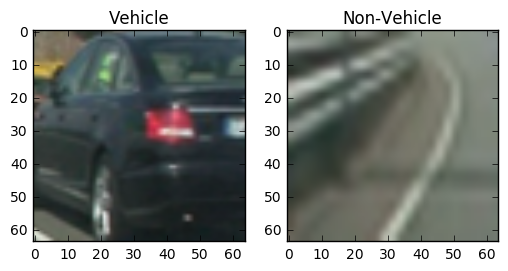

In [2]:
# Plot samples of vehicle and non-vehicle images.
example_vehicle = mpimg.imread('vehicles/GTI_Right/image0001.png')
example_vehicle1 = mpimg.imread('vehicles/GTI_Right/image0003.png')
example_nonvehicle = mpimg.imread('non-vehicles/GTI/image49.png')

fig = plt.figure()
plt.subplot(121)
plt.imshow(example_vehicle)
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(example_nonvehicle)
plt.title('Non-Vehicle')

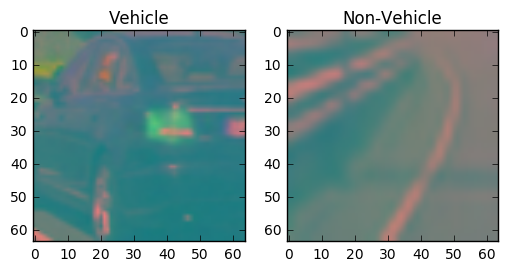

In [3]:
vehicle_yuv=cv2.cvtColor(example_vehicle, cv2.COLOR_RGB2YUV)
nonvehicle_yuv=cv2.cvtColor(example_nonvehicle,cv2.COLOR_RGB2YUV)
fig = plt.figure()
plt.subplot(121)
plt.imshow(vehicle_yuv)
plt.title('Vehicle')
plt.subplot(122)
plt.imshow(nonvehicle_yuv)
plt.title('Non-Vehicle')

64


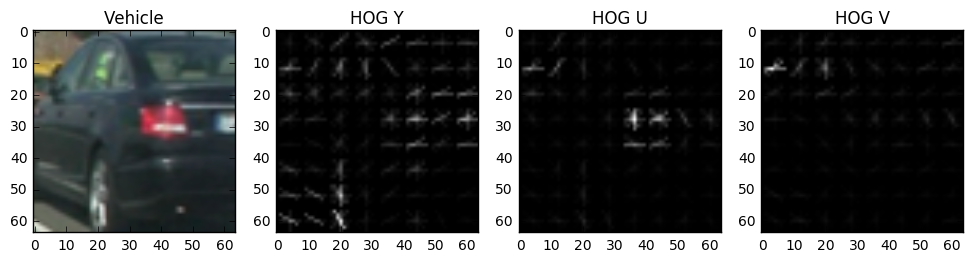

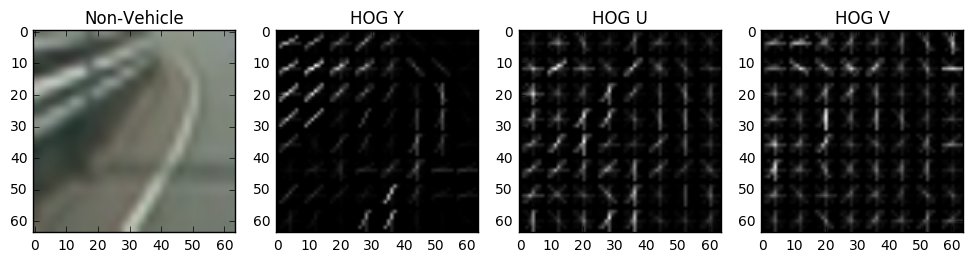

In [4]:
# HOG parameters
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = 8
HOG_CELLS_PER_BLOCK = 2

def hog_features_ski(channel, visualise=False):
    if visualise == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(channel, orientations=HOG_ORIENTATIONS,
                                  pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                                  cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        #print(hog_image.shape)
        return hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(channel, orientations=HOG_ORIENTATIONS,
                       pixels_per_cell=(HOG_PIXELS_PER_CELL, HOG_PIXELS_PER_CELL),
                       cells_per_block=(HOG_CELLS_PER_BLOCK, HOG_CELLS_PER_BLOCK),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

# Generate HOG visualization for example images.
hog_vehicle = [hog_features_ski(vehicle_yuv[:,:,i], visualise=True) for i in range(3)]
hog_non_vehicle = [hog_features_ski(nonvehicle_yuv[:,:,i], visualise=True) for i in range(3)]
print(len(hog_vehicle[0]))
fig = plt.figure(1, figsize=(12, 9))
plt.subplot(141)
plt.imshow(example_vehicle)
plt.title('Vehicle')
plt.subplot(142)
plt.imshow(hog_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_vehicle[2], cmap='gray')
plt.title('HOG V')
fig = plt.figure(2, figsize=(12,9))
plt.subplot(141)
plt.imshow(example_nonvehicle)
plt.title('Non-Vehicle')
plt.subplot(142)
plt.imshow(hog_non_vehicle[0], cmap='gray')
plt.title('HOG Y')
plt.subplot(143)
plt.imshow(hog_non_vehicle[1], cmap='gray')
plt.title('HOG U')
plt.subplot(144)
plt.imshow(hog_non_vehicle[2], cmap='gray')
plt.title('HOG V')


In [5]:
def init_hog(img_shape, orient=9, pix_per_cell=8, cell_per_block=2, reset=False):
    cell_size = (pix_per_cell, pix_per_cell)  # h x w in pixels
    block_size = (cell_per_block, cell_per_block)  # h x w in cells
    nbins = orient  # number of orientation bins

    # winSize is the size of the image cropped to an multiple of the cell size
    hog_desc = cv2.HOGDescriptor(_winSize=(img_shape[1] // cell_size[1] * cell_size[1],
                                          img_shape[0] // cell_size[0] * cell_size[0]),
                                _blockSize=(block_size[1] * cell_size[1],
                                            block_size[0] * cell_size[0]),
                                _blockStride=(cell_size[1], cell_size[0]),
                                _cellSize=(cell_size[1], cell_size[0]),
                                _nbins=nbins)

    return hog_desc

In [6]:
print("----")
print(vehicle_yuv[:,:,1].shape)
hog=init_hog(vehicle_yuv[:,:,1].shape)
image = (vehicle_yuv*255).astype(np.uint8)
#hog_features = hogd.compute(feature_image)
hog_features = hog.compute(image)[:,0]
print(hog_features.shape)

----
(64, 64)
(1764,)


In [7]:
def extract_features(img,hog):
    img = colorTransform(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

In [8]:
X_all = []
y_all = []
for filename in glob.glob('vehicles/*/*.png'):
    img = mpimg.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_y = (img[:,:,0]*255).astype(np.uint8)
    img_u = (img[:,:,1]*255).astype(np.uint8)
    img_v = (img[:,:,2]*255).astype(np.uint8)
    hog_features_y = hog.compute(img_y)[:,0]
    hog_features_u = hog.compute(img_u)[:,0]
    hog_features_v = hog.compute(img_v)[:,0]
    X_all.append(np.concatenate((hog_features_y, hog_features_u, hog_features_v)))
    y_all.append(True)
for filename in glob.glob('non-vehicles/*/*.png'):
    img = mpimg.imread(filename)
    img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_y = (img[:,:,0]*255).astype(np.uint8)
    img_u = (img[:,:,1]*255).astype(np.uint8)
    img_v = (img[:,:,2]*255).astype(np.uint8)
    hog_features_y = hog.compute(img_y)[:,0]
    hog_features_u = hog.compute(img_u)[:,0]
    hog_features_v = hog.compute(img_v)[:,0]
    X_all.append(np.concatenate((hog_features_y, hog_features_u, hog_features_v)))
    y_all.append(False)

In [9]:
print(len(X_all))
print(len(y_all))

17760
17760


In [10]:
Xscaler = StandardScaler().fit(X_all)
X_all = Xscaler.transform(X_all)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, stratify=y_all, random_state=1)

In [12]:
classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=1, tol=0.0001,
     verbose=0)

In [13]:
print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))

Vehicle classifier trained with test accuracy: 98.2%


In [14]:
BBOX_COLOR = (0, 0, 255)
BBOX_THICKNESS = 6

# This assumes incoming image is encoded RGB.
def draw_boxes(img, bboxes):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], BBOX_COLOR, BBOX_THICKNESS)
    return imcopy

In [15]:
def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=None,
                    xy_window=None, xy_overlap=(0.5, 0.5)):
    if xy_window is None:
        xy_window = (32, 32)
    if y_start_stop is None:
        y_start_stop = [None, None]
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 400
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [16]:
#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.cvtColor(img, cv2.COLOR_BGR2RGB)
#windows = slide_window(img.shape)
#img = draw_boxes(img, windows)
#plt.imshow(img)
#print(img.shape)

In [24]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    # img = (img*255).astype(np.uint8)
    #1) Create an empty list to receive positive detection windows
    plt.imshow(img)
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        plt.imshow(img)
        img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        img=cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        img_y = (img[:,:,0]*255).astype(np.uint8)
        img_u = (img[:,:,1]*255).astype(np.uint8)
        img_v = (img[:,:,2]*255).astype(np.uint8)
        hog_features_y = hog.compute(img_y)[:,0]
        hog_features_u = hog.compute(img_u)[:,0]
        hog_features_v = hog.compute(img_v)[:,0]
        features = np.concatenate((hog_features_y, hog_features_u, hog_features_v))
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        if clf.decision_function(test_features)>0.8 :
        #7) If positive (prediction == 1) then save the window
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

error: ..\..\..\modules\imgproc\src\imgwarp.cpp:3229: error: (-215) ssize.area() > 0 in function cv::resize


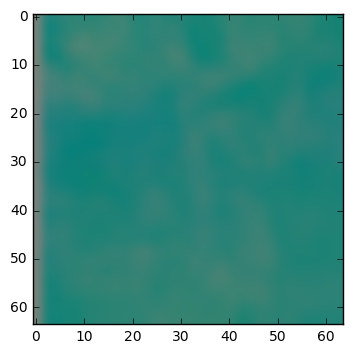

In [25]:
img = mpimg.imread('test_images/test1.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img.shape)
windows = search_windows(img, windows, classifier, Xscaler)
img = draw_boxes(img, windows)
plt.imshow(img)